In [1]:
# https://www.nurkiewicz.com/2020/03/see-how-google-is-tracking-your.html

# download Moscow map:
# http://casyfill.github.io/mosplus/#


In [2]:
import pandas as pd
import numpy as np
import geopandas as gp
import shapely.geometry as sg
import datetime as dt
from matplotlib import cm
from matplotlib.lines import Line2D
import json

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)


In [4]:

def start_location(datadict, workdict):
    workdict['longitude'].append(datadict['startLocation']['longitudeE7']/ 10000000)
    workdict['latitude'].append(datadict['startLocation']['latitudeE7']/ 10000000)
    workdict['timestamp'].append(datadict['duration']['startTimestampMs'])
    
    
def point_path(datadict, workdict):
    
    try:
        starttime = int(datadict['duration']['startTimestampMs'])
        endtime = int(datadict['duration']['endTimestampMs'])
        difference = endtime - starttime
        small_dif = difference//len(datadict['waypointPath']['waypoints'])
        temp_time = starttime
        for el in datadict['waypointPath']['waypoints']:
            workdict['longitude'].append(el['lngE7']/ 10000000)
            workdict['latitude'].append(el['latE7']/ 10000000)
            workdict['timestamp'].append(str(temp_time+small_dif))
            temp_time += small_dif
    except KeyError:
        pass
        
def end_location(datadict, workdict):
    workdict['longitude'].append(datadict['endLocation']['longitudeE7']/ 10000000)
    workdict['latitude'].append(datadict['endLocation']['latitudeE7']/ 10000000)
    workdict['timestamp'].append(datadict['duration']['endTimestampMs'])    
    

def parse_activitySegment(datadict, workdict):
    start_location(datadict, workdict)
    point_path(datadict, workdict)
    end_location(datadict, workdict)

    


In [5]:
moscow_build = gp.read_file('maps\mosbld\mosbld.shp')


In [6]:
def seconds(timestamp):
    return timestamp.to_pydatetime().timestamp()
 
 
def calculate_pal(df2, cmap):
    min_ts = seconds(df2.timestamp.min())
    max_ts = seconds(df2.timestamp.max())
    return df2.timestamp.apply(lambda ts: cmap((seconds(ts) - min_ts) / (max_ts - min_ts))).tolist()
 
 
def compute_legend(df, ax, cmap, steps):
    vals = [x / (steps - 1) for x in range(steps)]
    custom_lines = [Line2D([0], [0], color=cmap(step), lw=4) for step in vals]
    labels = [df.timestamp.quantile(step).strftime("%Y-%m-%d") for step in vals]
    ax.legend(custom_lines, labels, loc="lower left")
    
 
def draw_map(df, box):
    box_only = df[df.geometry.within(box)]

    minx, miny, maxx, maxy = box.bounds
    base = moscow_build.plot(color='white', edgecolor='silver', figsize=(12,10))
    base.set_xlim(minx, maxx)
    base.set_ylim(miny, maxy)
    cmap = cm.get_cmap('viridis')
    pal = calculate_pal(box_only, cmap)
    ax = box_only.plot(ax=base, marker='o', c=pal, markersize=10)
    compute_legend(box_only, ax, cmap, 5)

In [7]:
def prepare_data(filename):
    with open(filename, encoding='UTF-8') as f:
        loaded_json = json.loads(f.read())
    Dict = {'longitude': [], 'latitude': [], 'timestamp': []} 

    for el in loaded_json['timelineObjects']:
        if list(el.keys())[0] == 'activitySegment':
            parse_activitySegment(el['activitySegment'], Dict)
    df = pd.DataFrame.from_dict(Dict)
    df["timestamp"] = df["timestamp"].apply(lambda x: pd.to_datetime(x, unit='ms'))
    gdf = gp.GeoDataFrame(
        df, geometry=gp.points_from_xy(df.longitude, df.latitude))  
    return gdf


Bad key "text.kerning_factor" on line 4 in
C:\Users\Lera\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


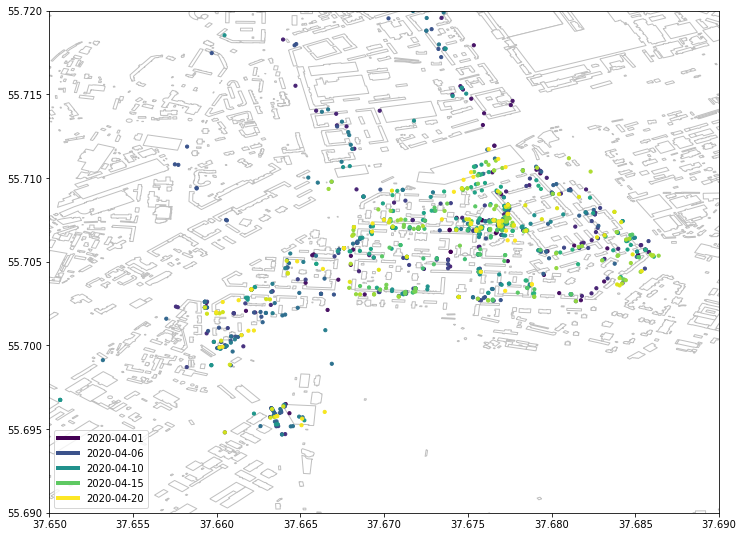

In [9]:
#close view
filename = r"google_lera\Takeout\История местоположений\Semantic Location History\2020\2020_APRIL.json"
gdf = prepare_data(filename)

draw_map(gdf, sg.box(37.65, 55.69, 37.69, 55.72))


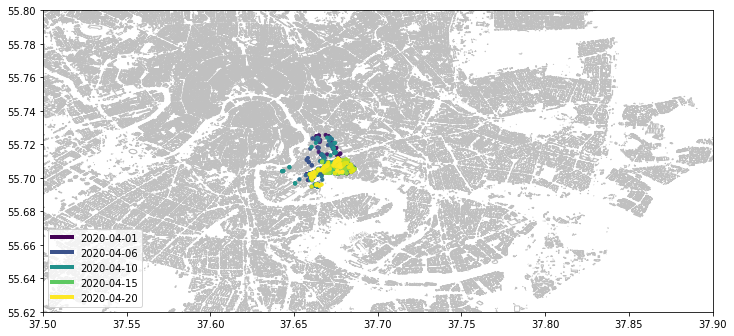

In [10]:
filename = r"google_lera\Takeout\История местоположений\Semantic Location History\2020\2020_APRIL.json"
gdf = prepare_data(filename)

draw_map(gdf, sg.box(37.5, 55.62, 37.9, 55.8))

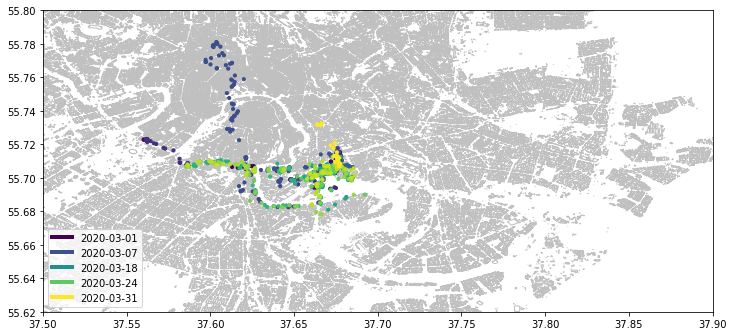

In [11]:
filename = r"google_lera\Takeout\История местоположений\Semantic Location History\2020\2020_MARCH.json"
gdf = prepare_data(filename)

draw_map(gdf, sg.box(37.5, 55.62, 37.9, 55.8))

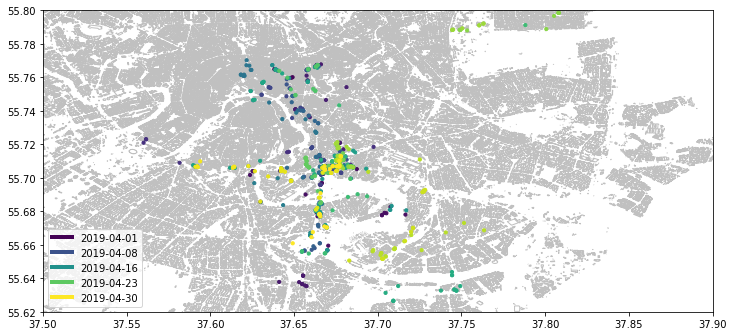

In [12]:
filename = r"google_lera\Takeout\История местоположений\Semantic Location History\2019\2019_APRIL.json"
gdf = prepare_data(filename)


draw_map(gdf, sg.box(37.5, 55.62, 37.9, 55.8))

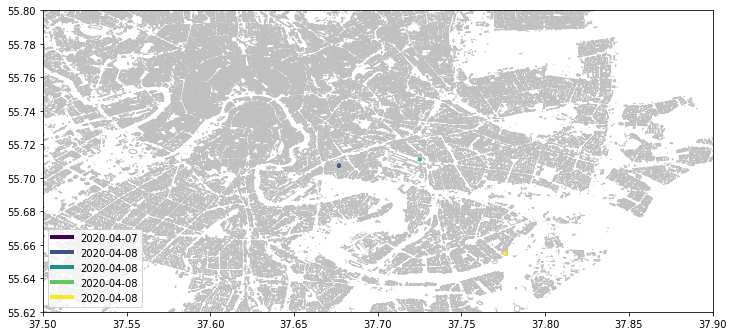

In [13]:
filename = r"google_vova\Takeout\История местоположений\Semantic Location History\2020\2020_APRIL.json"
gdf = prepare_data(filename)


draw_map(gdf, sg.box(37.5, 55.62, 37.9, 55.8))

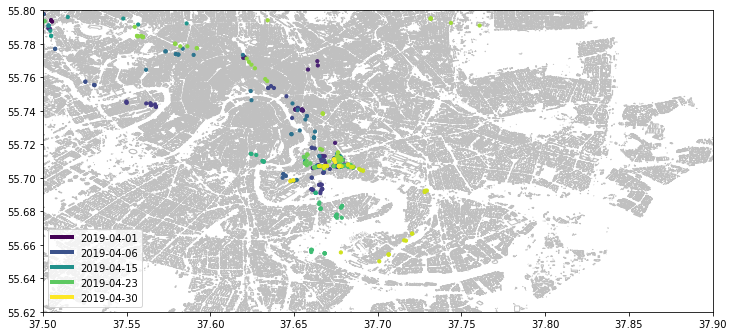

In [14]:
filename = r"google_vova\Takeout\История местоположений\Semantic Location History\2019\2019_APRIL.json"
gdf = prepare_data(filename)


draw_map(gdf, sg.box(37.5, 55.62, 37.9, 55.8))

In [ ]:
# draw_map(gdf, sg.box(37.63, 55.68, 37.69, 55.726))